# 0. Solution Planning

## 0.1. Input

1. Business Problem
    - Select most valuable clientsto be part of a loyalty program

2. Dataset
    - Sales from an e-commerce during one year

## 0.2. Output

1. People indication to be part of the loyalty program
    - List of clients tagged

2. Report with the business questions

    - Who are the elegible people to participate in the loyalty program?
    - How many clients will be part of the loyalty program?
    - Which are the main client characteristics?
    - What is the percentage of profit contribution that comes from the loyalty program?
    - What is the profit expectation from this group in the next months?
    - What are the conditions that makes someone elegible to the loyalty program?
    - What are the conditions that makes someone not elegible anymore to the loyalty program?
    - What are the metrics to decide if the loyalty program people are really better than the rest of the database?
    - What could the marketing team do to improve the profit?

## 0.3. Tasks

Who are the elegible people to participate in the loyalty program?
- High average ticket;
- High LTV (Life Time Value);
- High purchase frequency;
- High basket size;
- Low churn probability;
- High purchase propensity.
- Low number of devolutions;
- Experience;
- High number of ratings.

How many clients will be part of the loyalty program?
- Percentage of total clients.

What are the main client characteristics?
- Important client attributes (age, country, salary);
- Client purchasing behavior.

What is the percentage of profit contribution that comes from the loyalty program?
- Get the total profit of the company during the year and the percentage of the cluster.

What is the profit expectation from this group in the next months?
- Get the loyalty program LTV;
- Build a time series.

What are the conditions that make someone elegible to the loyalty program?
- The average performance of the client is close to the average performance of the clients from the loyalty program.

What are the conditions that make someone not elegible anymore to the loyalty program?
- The client average performance is not close to the loyalty program average anymore.

What are the metrics to decide if the loyalty program people are really better than the rest of the database?
- Hypothesis testing;
- A/B testing.

What could the marketing team do to improve the profit?
- Discounts;
- Choosing preferences;
- Exclusive products.

# 1. Imports

In [1]:
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

from sklearn import metrics
from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px
from sklearn import cluster as c
from sklearn import preprocessing as pp
from matplotlib import pyplot as plt

c:\Users\pma2022\anaconda3\envs\project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1. Helper Functions

In [2]:
def settings():

    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

settings()

## 1.2. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

df_raw.drop(columns=['Unnamed: 8'], inplace=True)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


# 2. Data Description

In [5]:
df1 = df_raw.copy()

## 2.1. Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 2.2. Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 2.3. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.4. Replace NA

In [9]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1 - (df1.shape[0] / df_raw.shape[0])) * 100))

Removed data: 24.93%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 2.6. Check Data Types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4. Change Data Types

In [12]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 2.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [15]:
num_attributes.head()

,quantity,unit_price,customer_id
0,6,2.5500,17850
1,6,3.3900,17850
2,8,2.7500,17850
3,6,3.3900,17850
4,6,3.3900,17850


In [16]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0000,80995.0000,161990.0000,12.0613,5.0000,248.6931,0.1827,94317.5637
1,unit_price,0.0000,38970.0000,38970.0000,3.4605,1.9500,69.3151,452.2190,246924.5430
2,customer_id,12346.0000,18287.0000,5941.0000,15287.6906,15152.0000,1713.5982,0.0298,-1.1800


1. Quantity with negative value;

2. Unit price equal to zero.

### 2.7.2. Categorical Attributes

In [17]:
cat_attributes.head()

,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,United Kingdom


In [18]:
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))

print('Total number of negative quantities with letter in the invoice: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices with letters: 8905
Total number of negative quantities with letter in the invoice: 8905


In [19]:
# stock_code
print('Number of stock codes with at least one letter: {}'.format(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())))

print('List of stock codes composed only by letters: {}'.format(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()))


Number of stock codes with at least one letter: 886
List of stock codes composed only by letters: ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']


In [20]:
# country
print('Number of countries in the database: {}'.format(len(df1['country'].unique())))
print('\nSome of these countries: \n{}'.format(df1['country'].value_counts(normalize=True).head(10)))

Number of countries in the database: 37

Some of these countries: 
United Kingdom   0.8895
Germany          0.0233
France           0.0209
EIRE             0.0184
Spain            0.0062
Netherlands      0.0058
Belgium          0.0051
Switzerland      0.0046
Portugal         0.0036
Australia        0.0031
Name: country, dtype: float64


# 3. Variable Filtering

In [21]:
df2 = df1.copy()

In [22]:
# unit price
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 4. Feature Engineering

In [23]:
df3 = df2.copy()

## 4.1. Feature Creation

In [24]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates(ignore_index=True)

In [25]:
# gross revenue (profit) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# recency (last day purchase)
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.loc[:, ['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# frequency
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# average ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# check na
df_ref.isna().sum()

C:\Users\pma2022\AppData\Local\Temp\ipykernel_28228\1661891643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [26]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.2100,372.0000,34.0000,18.1522
1,13047,3232.5900,56.0000,9.0000,18.9040
2,12583,6705.3800,2.0000,15.0000,28.9025
3,13748,948.2500,95.0000,5.0000,33.8661
4,15100,876.0000,333.0000,3.0000,292.0000


# 5. EDA (Exploratory Data Analysis)

In [27]:
df4 = df_ref.dropna().copy()

# 6. Data Preparation

In [28]:
df5 = df4.copy()

In [30]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 7. Feature Selection

In [31]:
df6 = df5.copy()

# 8. Hyperparameter Fine Tuning

In [32]:
X = df6.drop(columns=['customer_id'])

In [33]:
clusters = [2, 3, 4, 5, 6, 7]

## 8.1. Within Cluster Sum of Square (WSS)

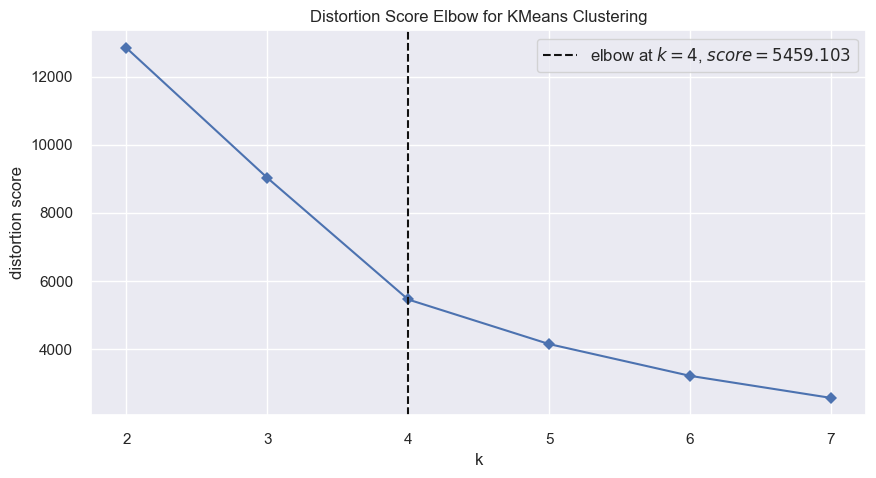

In [34]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 8.2. Silhouette Score

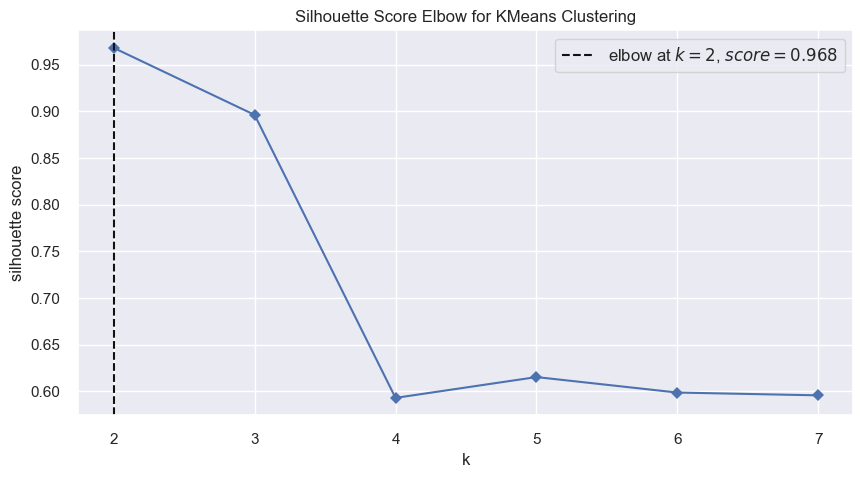

In [35]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 8.3. Silhouette Analysis

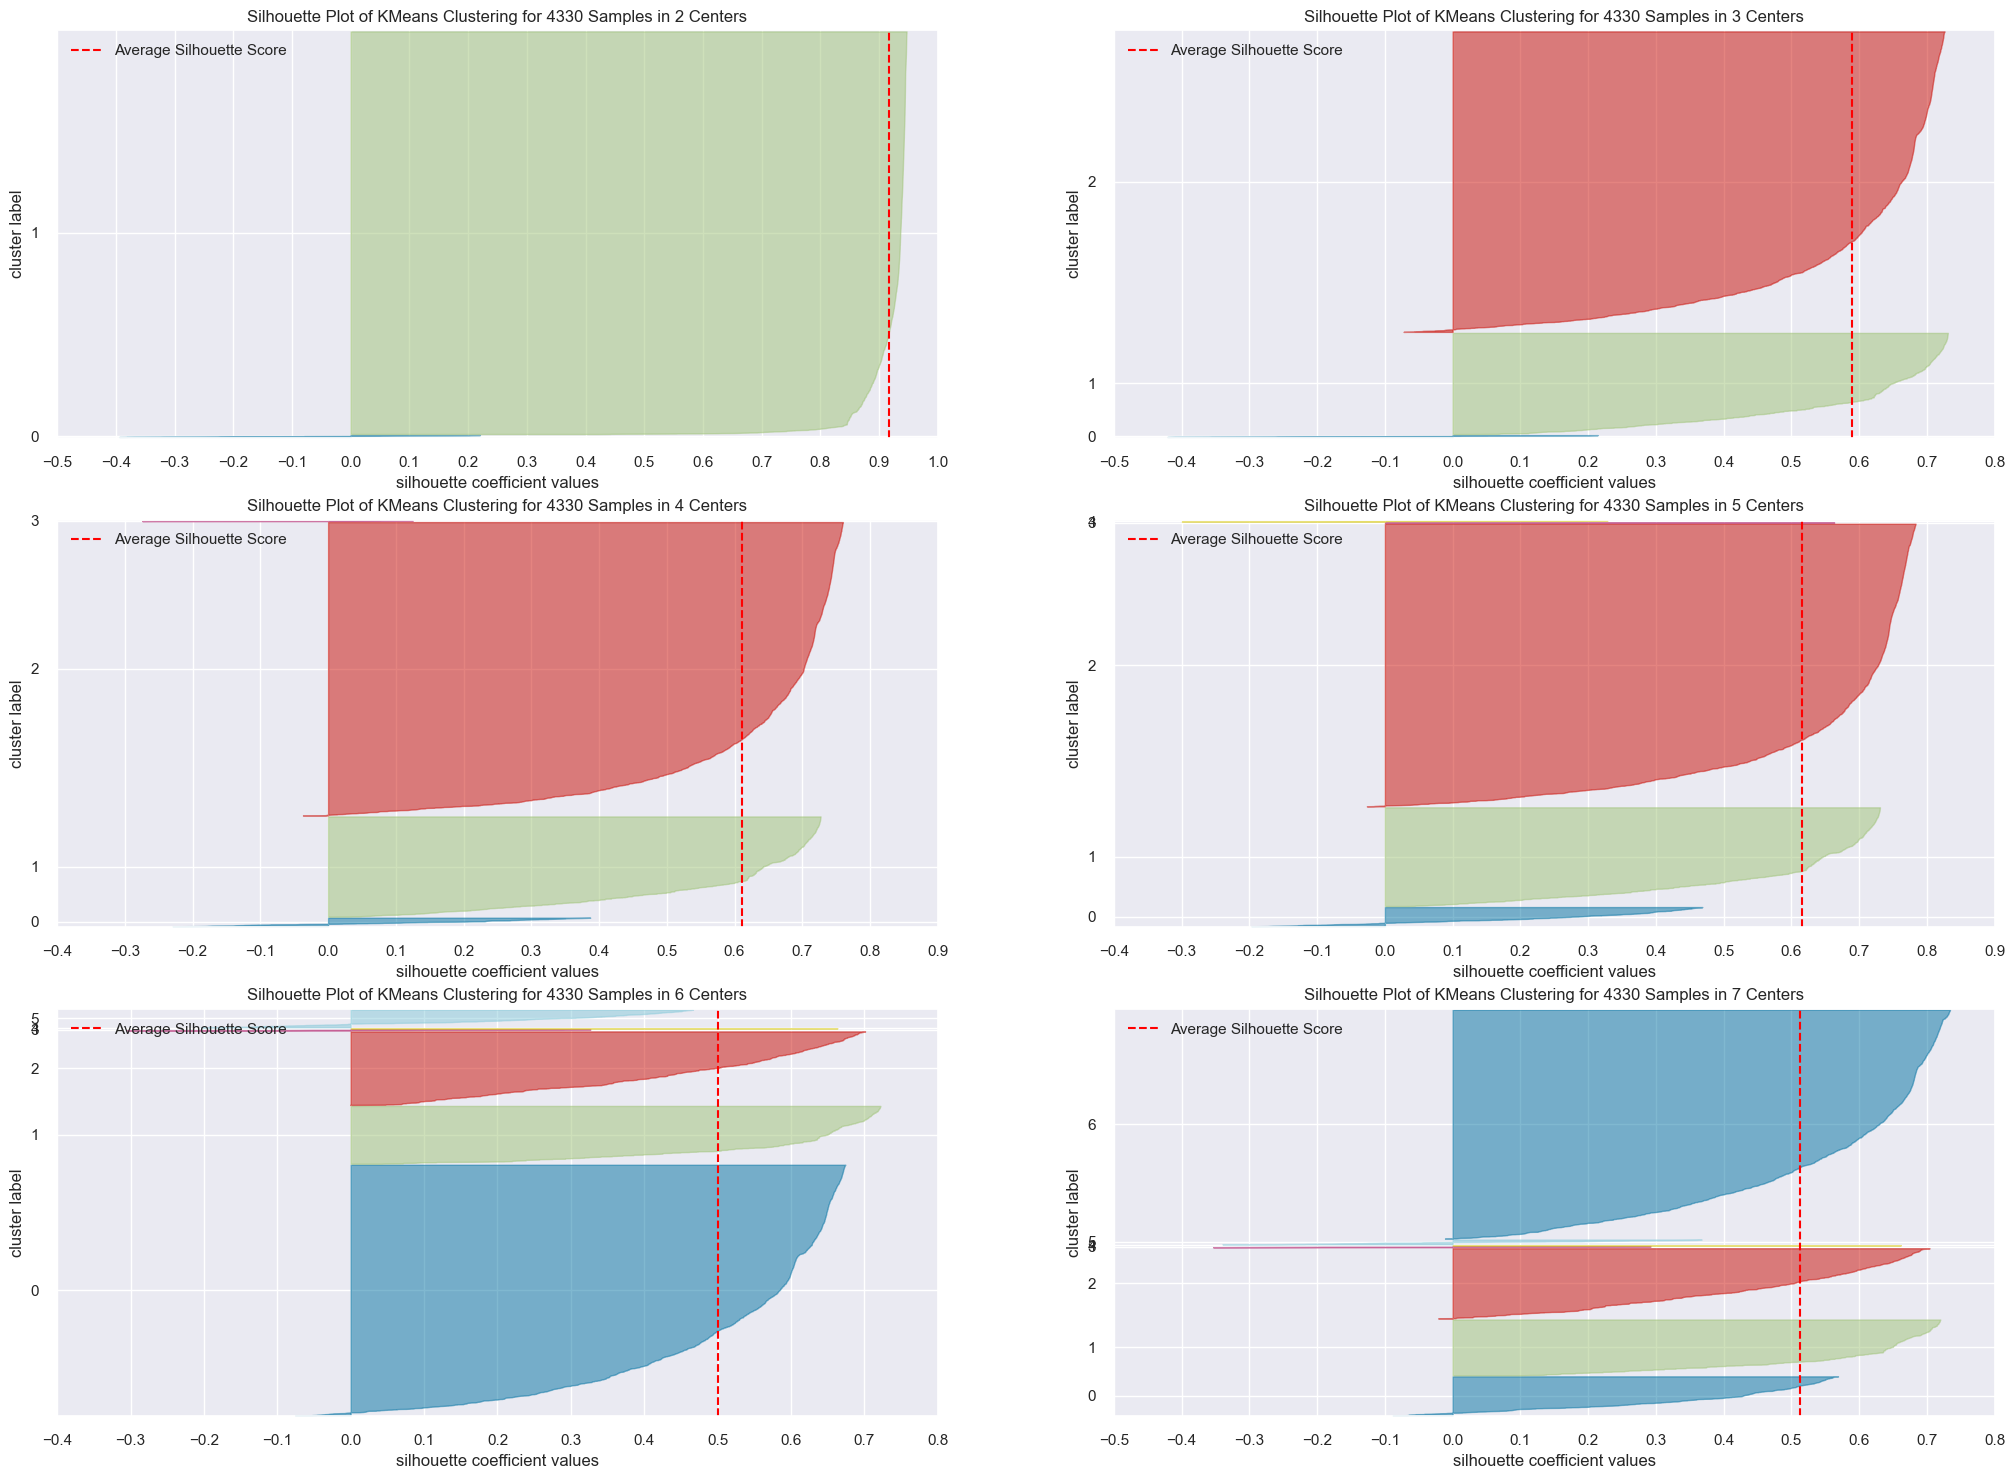

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 9. Model Training

## 9.1. K-Means

In [53]:
# model definition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 9.2. Cluster Validation

In [54]:
# WSS
print('WSS Value: {}'.format(kmeans.inertia_))

# SS
print('SS Value: {}'.format(metrics.silhouette_score(X, labels, metric='euclidean')))

WSS Value: 4152.047870028395
SS Value: 0.6154548703383368


# 10. Cluster Analysis

In [55]:
df9 = df6.copy()
df9['cluster'] = labels

## 10.1. Visualization Inspection

c:\Users\pma2022\anaconda3\envs\project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


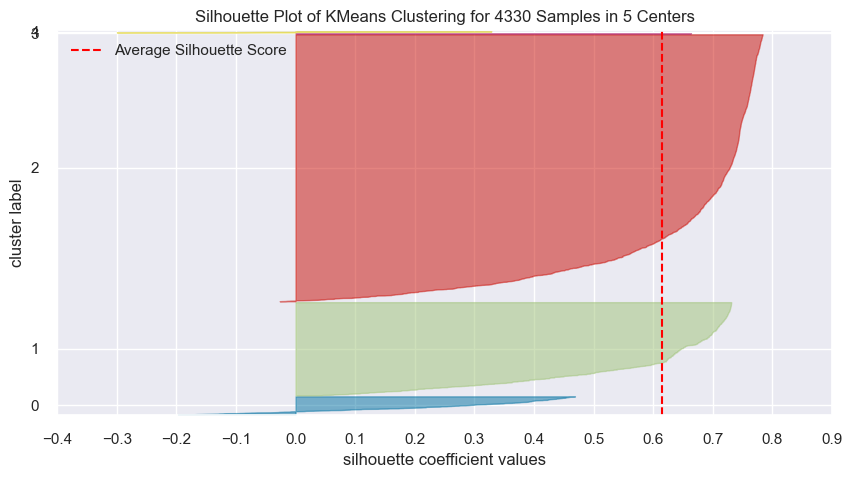

In [56]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 10.2. 2D Plot

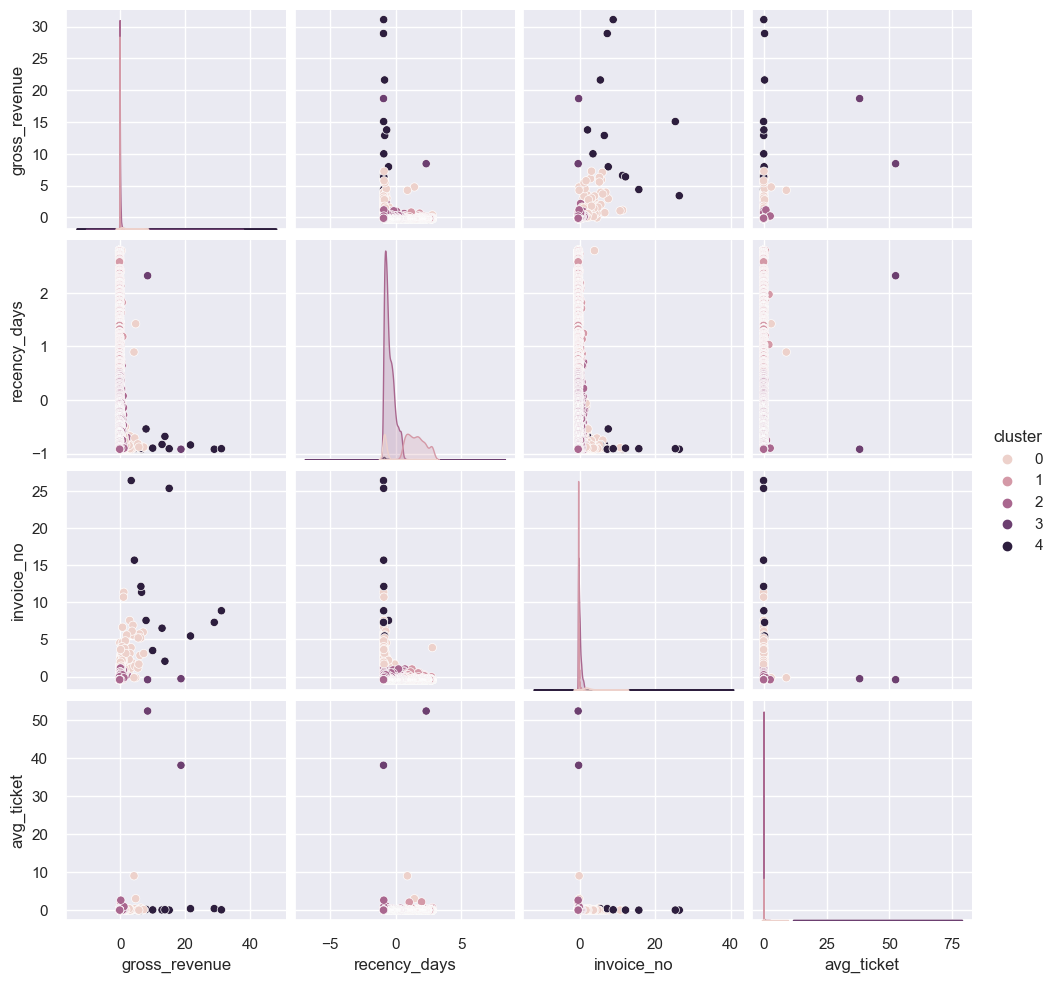

In [57]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 10.3. UMAP

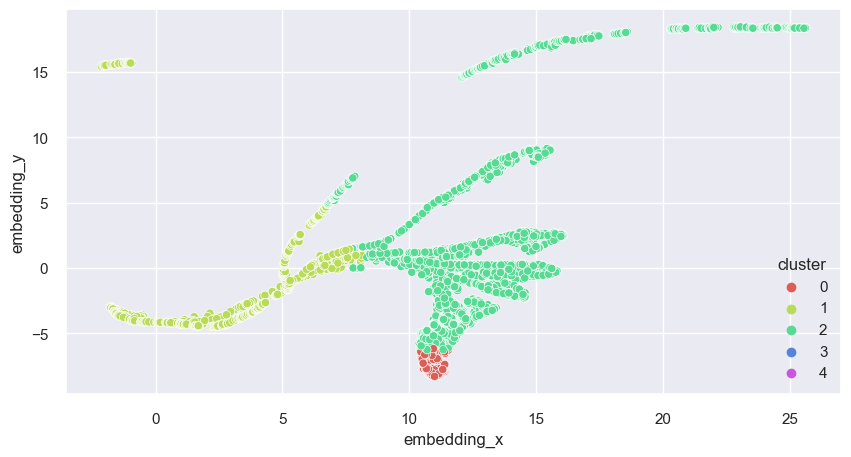

In [60]:
reducer = umap.UMAP(n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz);

## 10.2. Cluster Profile

In [59]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# average invoice number
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,208,4.8037,1.1146,-0.7861,2.3417,0.0480
1,1,1064,24.5727,-0.1737,1.5573,-0.3543,-0.0196
2,2,3044,70.3002,-0.0776,-0.4877,-0.0794,-0.0265
3,3,2,0.0462,13.5578,0.7015,-0.3598,45.3300
4,4,12,0.2771,13.4995,-0.8482,11.0141,0.0709


Cluster 1: (Insider)
- Customers: 6 (0.14%)
- Average Recency: 7 days
- Average Invoice Number: 89
- Average Gross Revenue: $ 182.181,98

Cluster 2:
- Customers: 6 (0.71%)
- Average Recency: 14 days
- Average Invoice Number: 53
- Average Gross Revenue: $ 40.543,52

CLuster 3:
- Customers: 6 (99,15%)
- Average Recency: 92 days
- Average Invoice Number: 5
- Average Gross Revenue: $ 1.372,57

# 11. Deployment